### Code to load the CNN Model and make predictions on the test set 

In [2]:
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
import re

In [3]:
df = pd.read_csv('../data/written_name_test_v2.csv')

In [4]:
df = df[df['IDENTITY'] != 'UNREADABLE']

In [5]:
df.head()

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN


In [6]:
name_cnts = df['IDENTITY'].value_counts()

In [7]:
name_cnts['NONE']

5

In [8]:
df[df['IDENTITY'] == 'NaN']

,FILENAME,IDENTITY


In [9]:
df = df[df['IDENTITY'].apply(isinstance, args=(str,))]

# Display non-string rows
df.shape

(41289, 2)

In [10]:
df['IDENTITY'] = df['IDENTITY'].str.upper()

In [11]:
df['IDENTITY_alpha'] = df['IDENTITY'].apply(lambda x: re.sub(r'[^a-zA-Z]', '', str(x)))
df['combined'] = df['FILENAME'] + ' ' + df['IDENTITY_alpha']
df.head()

,FILENAME,IDENTITY,IDENTITY_alpha,combined
0,TEST_0001.jpg,KEVIN,KEVIN,TEST_0001.jpg KEVIN
1,TEST_0002.jpg,CLOTAIRE,CLOTAIRE,TEST_0002.jpg CLOTAIRE
2,TEST_0003.jpg,LENA,LENA,TEST_0003.jpg LENA
3,TEST_0004.jpg,JULES,JULES,TEST_0004.jpg JULES
4,TEST_0005.jpg,CHERPIN,CHERPIN,TEST_0005.jpg CHERPIN


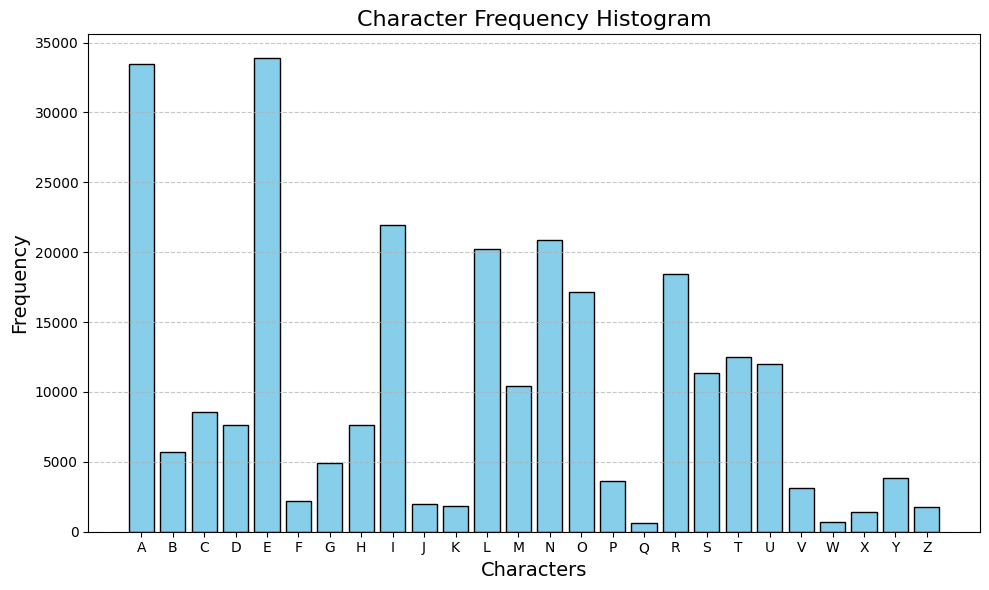

In [14]:
counts = Counter(''.join(df['IDENTITY_alpha']))


chars = sorted(counts.keys())  
counts_values = [counts[char] for char in chars]  


plt.figure(figsize=(10, 6))
plt.bar(chars, counts_values, color='skyblue', edgecolor='black')


plt.xlabel('Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Character Frequency Histogram', fontsize=16)


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()


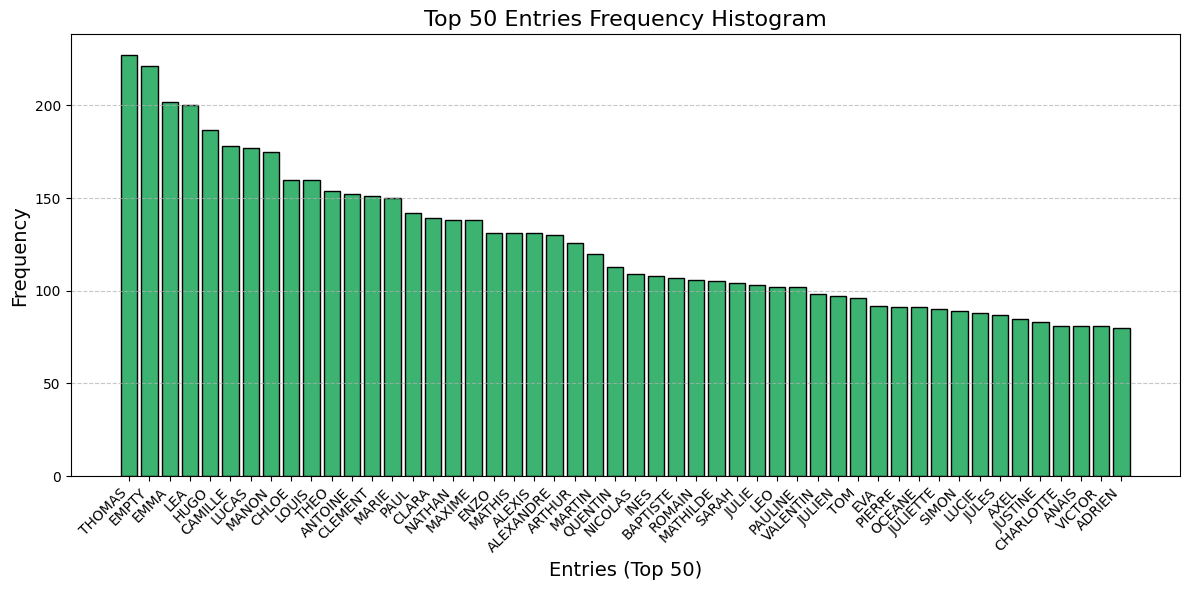

In [18]:
counts = Counter(df['IDENTITY_alpha'])


top_50 = counts.most_common(50)
entries_top = [item[0] for item in top_50]
counts_values_top = [item[1] for item in top_50]


plt.figure(figsize=(12, 6))
plt.bar(entries_top, counts_values_top, color='mediumseagreen', edgecolor='black')


plt.xlabel('Entries (Top 50)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 50 Entries Frequency Histogram', fontsize=16)


plt.xticks(rotation=45, ha='right', fontsize=10)


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()


In [24]:
def crop_top(image_path, pixels_to_crop):
    # Read the image
    image = cv2.imread(image_path)
    # plt.imshow(image)
    # Get the dimensions of the image
    height, width = image.shape[:2]
    
    # Crop 'pixels_to_crop' from the top
    cropped_image = image[0:height, pixels_to_crop:width]
    
    return cropped_image

In [25]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [26]:
def merge_bounding_boxes(cnts, merge_threshold=5):
    """
    Merges bounding boxes that are too close to each other based on a threshold.
    """
    # Get the bounding boxes for each contour
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    
    # Sort bounding boxes by x-coordinate (left-to-right)
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])
    
    merged_boxes = []
    for box in bounding_boxes:
        x, y, w, h = box
        if not merged_boxes:
            merged_boxes.append(box)
        else:
            # Check if the current box is close to the previous merged box
            prev_x, prev_y, prev_w, prev_h = merged_boxes[-1]
            
            # Check if they are close horizontally
            if x <= prev_x + prev_w + merge_threshold and abs(y - prev_y) < merge_threshold:
                # Merge the current box with the previous one
                new_x = min(prev_x, x)
                new_y = min(prev_y, y)
                new_w = max(prev_x + prev_w, x + w) - new_x
                new_h = max(prev_y + prev_h, y + h) - new_y
                merged_boxes[-1] = (new_x, new_y, new_w, new_h)
            else:
                merged_boxes.append(box)
    return merged_boxes

In [88]:
import cv2
import numpy as np
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt

def get_letters(img): 
    '''Input: image path'''
    letters = []
    image = crop_top(img, 0)  # Assuming crop_top is defined elsewhere
    plt.figure(figsize=(10, 10))
    plt.title("Original Image After Cropping")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 10))
    plt.title("Grayscale Image")
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.show()

    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    plt.figure(figsize=(10, 10))
    plt.title("Thresholded Image")
    plt.imshow(thresh1, cmap='gray')
    plt.axis('off')
    plt.show()

    dilated = cv2.dilate(thresh1, None, iterations=2)
    plt.figure(figsize=(10, 10))
    plt.title("Dilated Image")
    plt.imshow(dilated, cmap='gray')
    plt.axis('off')
    plt.show()

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            roi = gray[y:y + h, x:x + w]
            plt.figure(figsize=(5, 5))
            plt.title("Region of Interest (ROI)")
            plt.imshow(roi, cmap='gray')
            plt.axis('off')
            plt.show()

            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            plt.figure(figsize=(5, 5))
            plt.title("Thresholded ROI")
            plt.imshow(thresh, cmap='gray')
            plt.axis('off')
            plt.show()

            height, width = roi.shape[:2]
            area = width * height

            inner_cnts = [c]
            if (height >= 12 and area < 800):
                inner_cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                inner_cnts = imutils.grab_contours(inner_cnts)
                inner_cnts = sort_contours(inner_cnts, method="left-to-right")[0]

            for ic in inner_cnts:
                (ix, iy, iw, ih) = cv2.boundingRect(ic)
                if iw * ih > 0:
                    pad = 1
                    x1 = max(ix - pad, 0)
                    y1 = max(iy - pad, 0)
                    x2 = min(ix + iw + pad, thresh.shape[1])
                    y2 = min(iy + ih + pad, thresh.shape[0])
                    letter_roi = thresh[y1:y2, x1:x2]

                    if letter_roi.size > 0:
                        resized_letter = cv2.resize(letter_roi, (28, 28), interpolation=cv2.INTER_CUBIC)
                        resized_letter = resized_letter.astype("float32") / 255.0
                        resized_letter = np.expand_dims(resized_letter, axis=-1)

                        plt.figure(figsize=(2, 2))
                        plt.title("Extracted Letter")
                        plt.imshow(resized_letter.squeeze(), cmap='gray')
                        plt.axis('off')
                        plt.show()

                        letters.append(resized_letter)

    return letters, image


In [32]:
dir_path = os.path.join('..','data', 'test_v2', 'test')

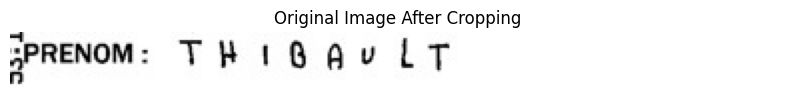

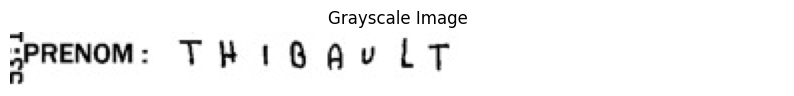

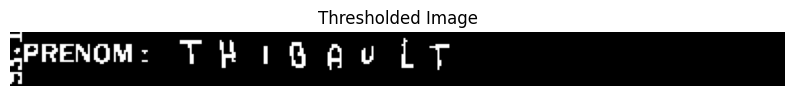

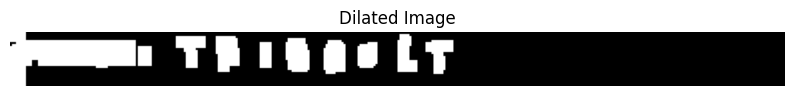

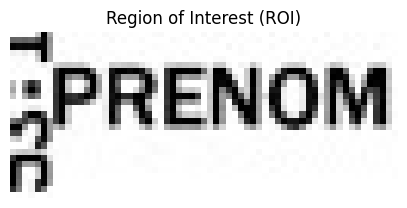

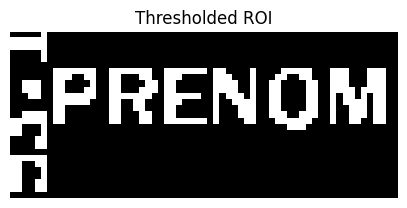

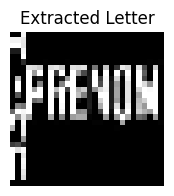

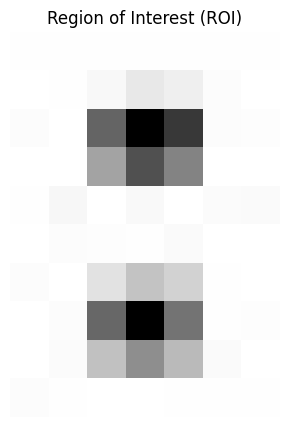

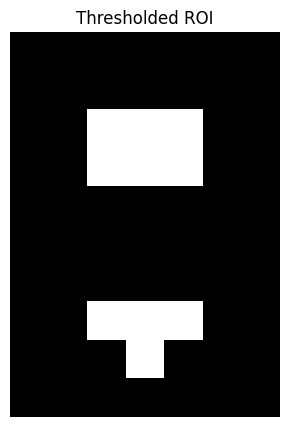

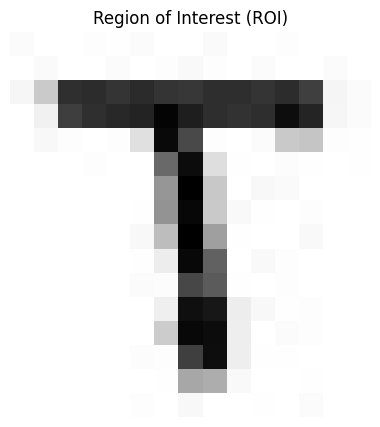

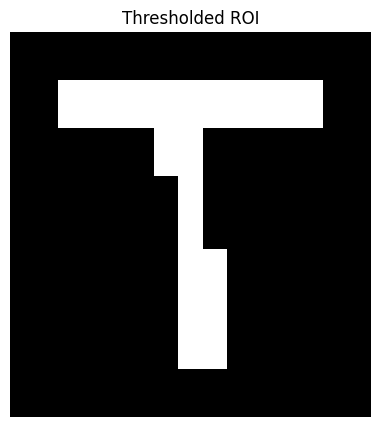

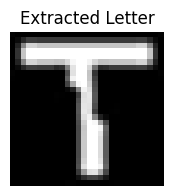

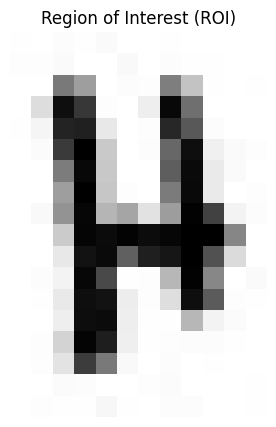

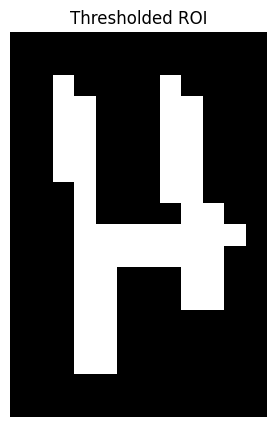

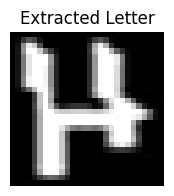

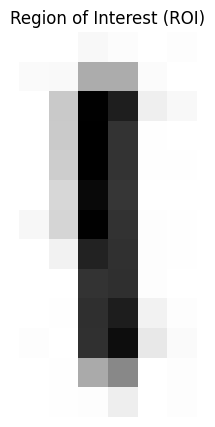

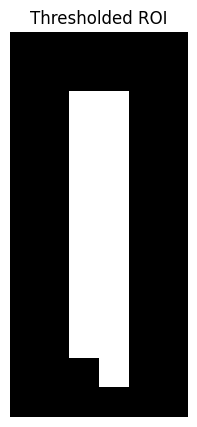

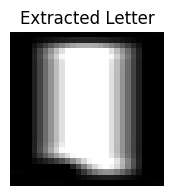

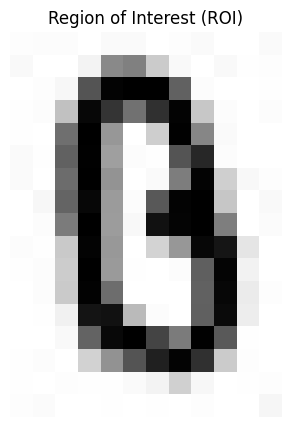

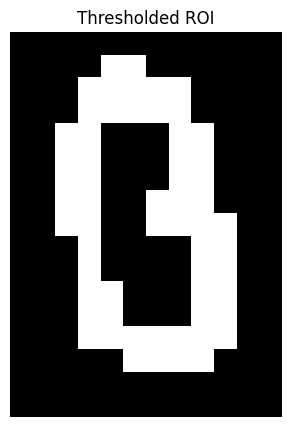

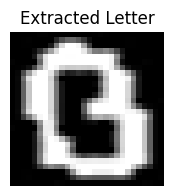

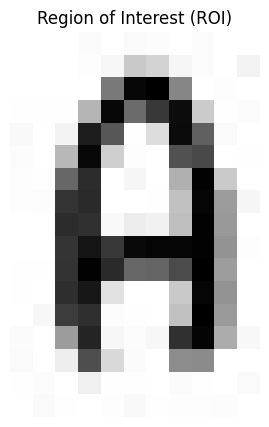

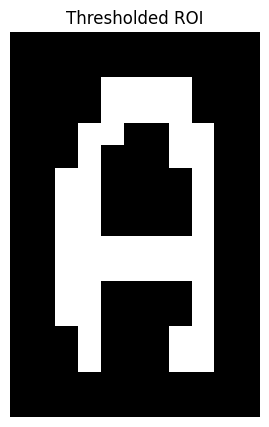

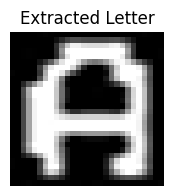

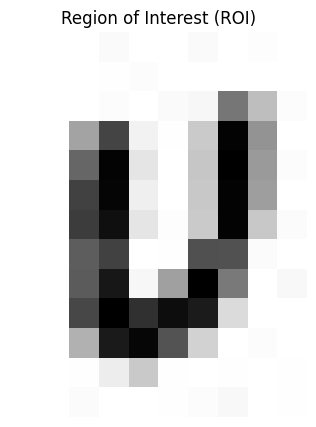

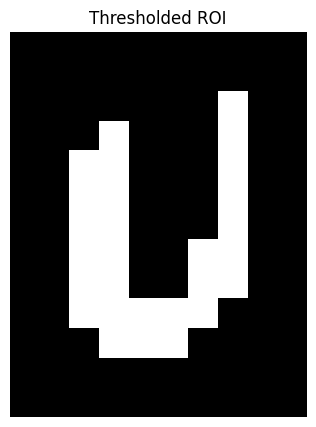

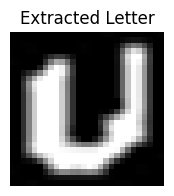

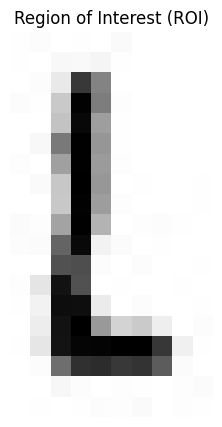

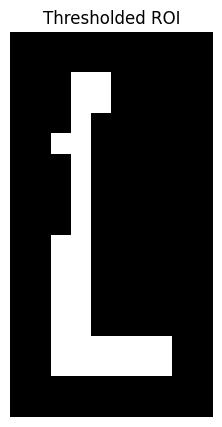

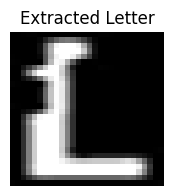

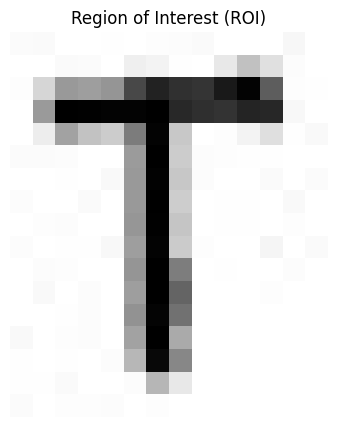

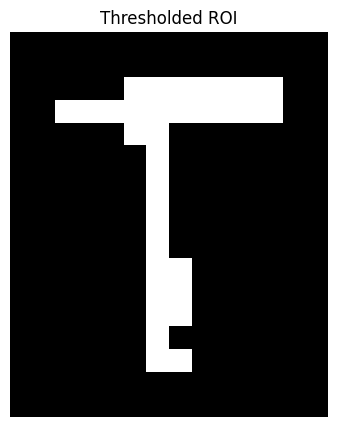

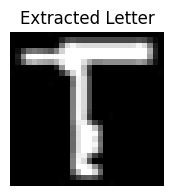

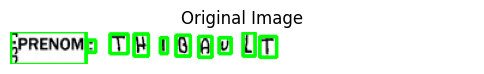

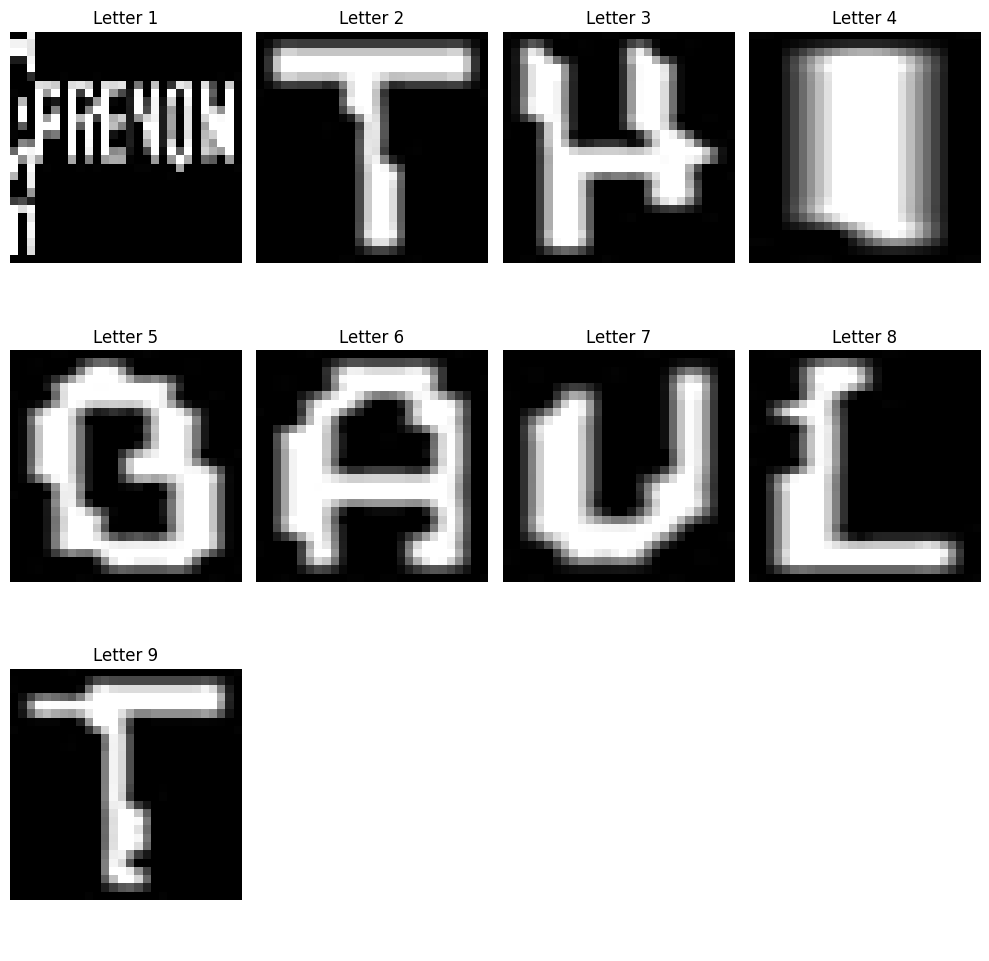

In [89]:
path = os.path.join(dir_path, 'TEST_0009.jpg')
letters, image = get_letters(path)


plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


num_letters = len(letters)
cols = int(num_letters**0.5) + 1  
rows = (num_letters // cols) + 1  


fig, axs = plt.subplots(rows, cols, figsize=(10, 10))


axs = axs.flatten()


for i, letter in enumerate(letters):
    axs[i].imshow(letter.squeeze(), cmap='gray')
    axs[i].set_title(f'Letter {i+1}')
    axs[i].axis('off')


for j in range(i + 1, len(axs)):
    axs[j].axis('off')


plt.tight_layout()
plt.show()


In [76]:
total = len(df)
cnt = 0

In [77]:
df['combined'][100]

'TEST_0101.jpg LADU'

In [78]:
import tensorflow as tf

In [44]:
from keras.models import load_model

# Model was trained on characters extracted from the dataa
model = load_model('Model/cnn_10k.keras')

KeyboardInterrupt: 

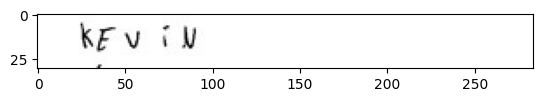

In [45]:
import numpy as np
import os
import pandas as pd

# Define the output CSV file path
output_csv = 'predictions_cnn.csv'

# Check if the CSV exists; if not, create it with the correct columns
if not os.path.exists(output_csv):
    pd.DataFrame(columns=['filename', 'predicted_string']).to_csv(output_csv, index=False)

# Loop through the entries and make predictions
for com in df['combined']:
    try:
        X = []
        # Split the combined entry into filename and name
        filename, name = com.split()
        path = os.path.join(dir_path, filename)
        
        # Extract letters and image using your custom function
        letters, image = get_letters(path)
        
        # Preprocess each letter and store it in X
        for x in letters:
            x = np.array(x).reshape(28, 28, 1)  # Reshape each letter to (28, 28, 1)
            X.append(x)
        
        # Convert X to a numpy array with shape (batch_size, 28, 28, 1)
        X = np.array(X)
        
        # Make predictions
        predictions = model.predict(X)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Convert predictions to a string of letters
        predicted_string = ''.join([chr(ord('A') + x) for x in predicted_classes])
        print(f"Predicted: {predicted_string}")
        
        # Create a DataFrame for the current prediction
        new_row = pd.DataFrame({'filename': [filename], 'predicted_string': [predicted_string]})
        
        # Append the new row to the CSV file
        new_row.to_csv(output_csv, mode='a', header=False, index=False)
    
    except Exception as error:
        new_row = pd.DataFrame({'filename': [filename], 'predicted_string': ['ERROR']})
        
        # Append the new row to the CSV file
        new_row.to_csv(output_csv, mode='a', header=False, index=False)
        print(f"Error occurred: {error}")


In [82]:
print(cnt/total)

0.0


In [48]:
df.head()

,FILENAME,IDENTITY,IDENTITY_alpha,combined
0,TEST_0001.jpg,KEVIN,KEVIN,TEST_0001.jpg KEVIN
1,TEST_0002.jpg,CLOTAIRE,CLOTAIRE,TEST_0002.jpg CLOTAIRE
2,TEST_0003.jpg,LENA,LENA,TEST_0003.jpg LENA
3,TEST_0004.jpg,JULES,JULES,TEST_0004.jpg JULES
4,TEST_0005.jpg,CHERPIN,CHERPIN,TEST_0005.jpg CHERPIN


In [52]:
pred_df = pd.read_csv('predictions_cnn.csv', header = None)

In [53]:
pred_df.head()

,0,1
0,TEST_0001.jpg,KFVN
1,TEST_0002.jpg,O
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,VLES
4,TEST_0005.jpg,CHEBPIN


In [54]:
df.shape

(41289, 4)

In [55]:
pred_df = pred_df.rename(columns={0: 'FILENAME'})

In [56]:
merged_df = pd.merge(df, pred_df, on='FILENAME', how='inner')

In [57]:
merged_df.head()

,FILENAME,IDENTITY,IDENTITY_alpha,combined,1
0,TEST_0001.jpg,KEVIN,KEVIN,TEST_0001.jpg KEVIN,KFVN
1,TEST_0002.jpg,CLOTAIRE,CLOTAIRE,TEST_0002.jpg CLOTAIRE,O
2,TEST_0003.jpg,LENA,LENA,TEST_0003.jpg LENA,LENA
3,TEST_0004.jpg,JULES,JULES,TEST_0004.jpg JULES,VLES
4,TEST_0005.jpg,CHERPIN,CHERPIN,TEST_0005.jpg CHERPIN,CHEBPIN


In [58]:
np.sum(merged_df[1] == merged_df['IDENTITY_alpha'])/len(merged_df)

0.41102957204097945

In [59]:
df['predictions'] = pred_df[1]

In [60]:
np.sum(df['predictions'] == df['IDENTITY_alpha'])

437

In [61]:
df.shape

(41289, 5)

In [77]:
merged_df.head()

,FILENAME,IDENTITY,IDENTITY_alpha,combined,1
0,TEST_0001.jpg,KEVIN,KEVIN,TEST_0001.jpg KEVIN,KFVN
1,TEST_0002.jpg,CLOTAIRE,CLOTAIRE,TEST_0002.jpg CLOTAIRE,O
2,TEST_0003.jpg,LENA,LENA,TEST_0003.jpg LENA,LENA
3,TEST_0004.jpg,JULES,JULES,TEST_0004.jpg JULES,VLES
4,TEST_0005.jpg,CHERPIN,CHERPIN,TEST_0005.jpg CHERPIN,CHEBPIN


In [68]:
from Levenshtein import distance as levenshtein_distance

def calculate_cer(predictions, ground_truths):
    total_chars = 0
    total_errors = 0
    length = 0
    for pred, truth in zip(predictions, ground_truths):
        # print(pred, truth)
        try:
            length += 1
            total_errors += levenshtein_distance(pred, truth)
            total_chars += len(truth)
            # print(levenshtein_distance(pred, truth)/len(truth))
        except:
            continue
    cer = total_errors / total_chars
    return cer

In [69]:
calculate_cer(merged_df['IDENTITY_alpha'], merged_df[1])

0.22469824996387366

In [83]:
y_true = merged_df.loc[0:len(merged_df), 'IDENTITY_alpha']
prediction = merged_df.loc[0:len(merged_df), 1]
correct_char = 0
total_char = 0
correct = 0

for i in range(len(merged_df)):
    try:
        pr = prediction[i]
        tr = y_true[i]
        
        # print(tr)
        total_char += len(tr)
        
        for j in range(min(len(tr), len(pr))):
            if tr[j] == pr[j]:
                correct_char += 1
                
        if pr == tr :
            correct += 1 
    except Exception as poo:
        # print(poo)
        continue
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(merged_df)))

Correct characters predicted : 74.66%
Correct words predicted      : 54.33%


In [84]:
from collections import defaultdict


y_true = merged_df.loc[:, 'IDENTITY_alpha']
prediction = merged_df.loc[:, 1]


char_counts = defaultdict(lambda: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0})


for i in range(len(merged_df)):
    try:
        pr = prediction[i]
        tr = y_true[i]

        
        true_chars = set(tr)
        pred_chars = set(pr)

        
        for char in true_chars.union(pred_chars):
            if char in true_chars and char in pred_chars:
                
                char_counts[char]['TP'] += min(tr.count(char), pr.count(char))
            if char not in true_chars and char in pred_chars:
                
                char_counts[char]['FP'] += pr.count(char)
            if char in true_chars and char not in pred_chars:
                
                char_counts[char]['FN'] += tr.count(char)

    except Exception as e:
        print(f"Error at index {i}: {e}")
        continue


f1_scores = {}
for char, counts in char_counts.items():
    TP, FP, FN = counts['TP'], counts['FP'], counts['FN']
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    f1_scores[char] = f1


print(f"{'Character':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}")
for char in sorted(f1_scores.keys()):
    TP, FP, FN = char_counts[char]['TP'], char_counts[char]['FP'], char_counts[char]['FN']
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = f1_scores[char]
    print(f"{char:<10}{precision:<10.2f}{recall:<10.2f}{f1:<10.2f}")


overall_f1 = sum(f1_scores.values()) / len(f1_scores)
print(f"\nOverall F1-Score: {overall_f1:.2f}")


Error at index 165: 'float' object is not iterable
Error at index 4996: 'float' object is not iterable
Error at index 30204: 'float' object is not iterable
Error at index 31365: 'float' object is not iterable
Character Precision Recall    F1-Score  
A         0.99      0.92      0.95      
B         0.86      0.89      0.87      
C         0.90      0.91      0.91      
D         0.89      0.89      0.89      
E         0.99      0.93      0.96      
F         0.73      0.92      0.82      
G         0.74      0.90      0.81      
H         0.90      0.85      0.88      
I         0.95      0.81      0.88      
J         0.59      0.90      0.71      
K         0.81      0.91      0.86      
L         0.98      0.90      0.94      
M         0.84      0.89      0.87      
N         0.98      0.89      0.93      
O         0.93      0.89      0.91      
P         0.85      0.88      0.86      
Q         0.42      0.87      0.56      
R         0.90      0.92      0.91      
S         0.

In [86]:
merged_df.to_csv('predictions_cnn.csv', columns = ['FILENAME', 1])